# Solving the 2D Steady-State Heat Equation using Finite Differences

In this example, we solve the steady-state 2D heat equation (Poisson equation) in a rectangular domain $ x \in [0, 2], \ y \in [0, 4] $ using finite difference methods. The equation is given by:

$$
\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0
$$

with Dirichlet boundary conditions:

- At $ y = 0 $:                       
  - $T(x, 0) = -(T_{max} - T_{bound})(x - 1)^2 + T_{max}$ [$K$]
  - $T_{max} = 500 K$
- At $ y = 4 $, $ x = 0 $, $ x = 2 $: 
  - $T = T_{bound} = 400 K$

**Note on corner continuity:** The quadratic boundary condition at $y = 0$ is specifically designed so that $T(0, 0) = T(2, 0) = T_{bound} = 400 K$. This ensures that the boundary values at the bottom-left and bottom-right corners match the lateral boundary values exactly, eliminating any ambiguity or need to average corner values.

The solution involves:

1. Discretizing the domain using finite differences.
2. Constructing the Poisson matrix.
3. Applying boundary conditions to modify the right-hand side of the linear system.
4. Solving the resulting linear system for the unknown interior points.

In [ ]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

In [2]:
def solve_poisson(
    N_x: int, L_x: float, L_y: float, f_boundary: callable, T_bound: float
) -> np.ndarray:
    """
    Solves the 2D steady-state heat equation (Poisson equation) on a rectangular domain
    using finite differences with equal step sizes in x and y.

    Parameters
    ----------
    N_x : int
        Number of grid points in the x-direction.
    L_x : float
        Length of the domain in the x-direction.
    L_y : float
        Length of the domain in the y-direction.
    f_boundary : callable
        Function defining the quadratic boundary condition at y=0.
    T_bound : float
        Constant boundary value at y=4, x=0, and x=2.

    Returns
    -------
    u : np.ndarray
        2D array of the solution u(x, y) including boundary points.
    """
    # Compute the number of grid points in y to ensure equal step size
    dx = L_x / (N_x - 1)
    N_y = int(L_y / dx) + 1

    # Domain discretization
    x = np.linspace(0, L_x, N_x)
    y = np.linspace(0, L_y, N_y)

    # Number of unknowns
    N = (N_x - 2) * (N_y - 2)

    # Construct the Laplacian operator using finite differences
    diagonal = -4
    off_diagonal_x = 1
    off_diagonal_y = 1

    # Main diagonal
    main_diag = np.full(N, diagonal)
    # Off-diagonals: 
    # create the off-diagonal entries of the Poisson matrix that represent 
    # the coupling between neighboring points in the discretized 2D domain
    off_diag_x_vals = np.full(N - 1, off_diagonal_x)              # adjacent points in x-direction
    off_diag_y_vals = np.full(N - (N_x - 2), off_diagonal_y)      # adjacent points in y-direction

    # Adjust for boundary conditions
    for j in range(1, N_y - 2):
        idx = j * (N_x - 2) - 1
        off_diag_x_vals[idx] = 0   # to insert the zeros interupting the upper and lower diagonals

    diagonals = [
        main_diag,
        off_diag_x_vals,
        off_diag_x_vals,
        off_diag_y_vals,
        off_diag_y_vals,
    ]
    offsets = [0, -1, 1, -(N_x - 2), N_x - 2]

    A = diags(diagonals, offsets, shape=(N, N), format="csr")

    # Apply boundary conditions
    # Right-hand side vector
    b = np.zeros(N)

    # Apply boundary conditions
    idx_bottom = np.arange(0, N_x - 2)
    idx_top = np.arange(N-(N_x-2), N)
    # The +1 offset in the line below is needed because idx_bottom refers to indices in the interior points vector
    # (which excludes boundaries), while x is the full grid (which includes boundaries).
    # Interior point index 0 corresponds to x[1], index 1 to x[2], ..., up to index N_x-3 corresponding to x[N_x-2].
    b[idx_bottom] -= off_diagonal_y * f_boundary(x[idx_bottom +1], T_bound)     # Bottom boundary --> T(3)
    b[idx_top] -= off_diagonal_y * T_bound                                      # Top boundary --> T(4)

    idx_left = np.arange(0, N-(N_x-2)+1, N_x - 2)
    idx_right = np.arange((N_x-2) - 1, N+1, N_x - 2)
    b[idx_left] -= off_diagonal_x * T_bound                                     # Left boundary --> T(1)
    b[idx_right] -= off_diagonal_x * T_bound                                    # Right boundary --> T(2)

    # Solve the linear system
    u_inner = spsolve(A, b)

    # Construct the full solution including boundaries
    u = np.zeros((N_x, N_y))

    # Insert the interior solution
    u[1:-1, 1:-1] = u_inner.reshape((N_y - 2, N_x - 2)).T   # Reshape the vector to match the actual field

    # Apply boundary conditions
    # Bottom boundary y=0
    u[:, 0] = f_boundary(x, T_bound)
    # Top boundary y=4
    u[:, -1] = T_bound
    # Left boundary x=0
    u[0, :] = T_bound
    # Right boundary x=2
    u[-1, :] = T_bound

    return u

### Define the quadratic boundary condition in y=0

In [3]:
def quadratic_boundary(x: np.ndarray, T_bound: float) -> np.ndarray:
    """
    Defines the quadratic boundary condition at y=0.

    Parameters
    ----------
    x : np.ndarray
        Array of x-coordinate values.
    T_bound : float
        Temperature at the lateral boundaries (to ensure continuity)
        
    Returns
    -------
    np.ndarray
        Quadratic function evaluated at x.
    """
    T_max = 500
    T_c = T_max - T_bound
    return -T_c*(x - 1)**2 + T_max

### Solve the PDE in the defined domain

In [4]:
N_x = 100  # Number of grid points in the x-direction
L_x = 2   # Length of the domain in the x-direction
L_y = 4   # Length of the domain in the y-direction
T_bound = 400  # Example constant boundary value

u = solve_poisson(N_x, L_x, L_y, quadratic_boundary, T_bound)

### Plot the results

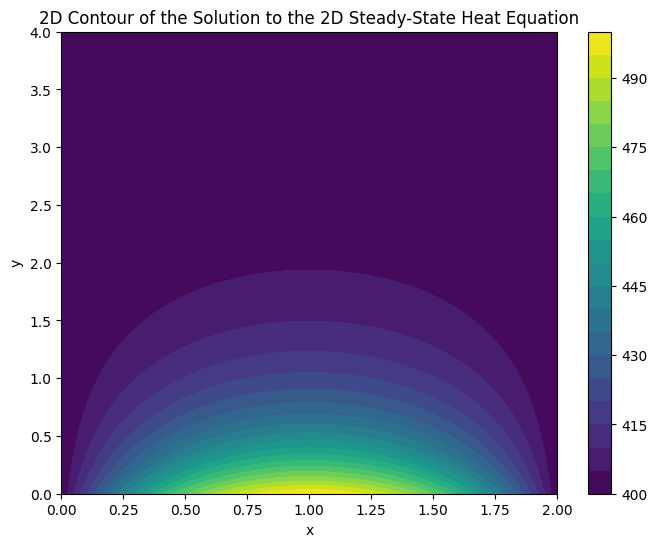

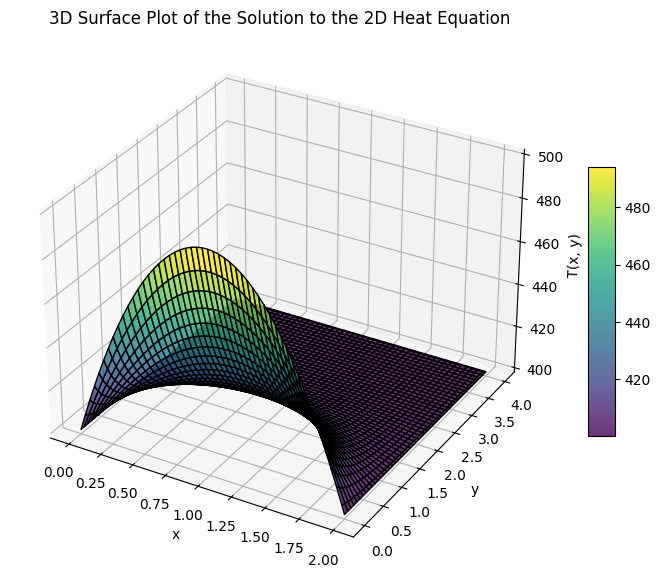

In [5]:
# Domain grid
x = np.linspace(0, L_x, N_x)
y = np.linspace(0, L_y, int(L_y / (L_x / (N_x - 1))) + 1)
X, Y = np.meshgrid(x, y, indexing="ij")

# 2D Contour plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(X, Y, u, 20, cmap="viridis")
plt.colorbar(cp)
plt.title("2D Contour of the Solution to the 2D Steady-State Heat Equation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# 3D Surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, u, cmap="viridis", edgecolor='k', alpha=0.8)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("3D Surface Plot of the Solution to the 2D Heat Equation")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("T(x, y)")
plt.show()